# 데이터, 패키지 로드

In [1]:
# 패키지
import pandas as pd 
import matplotlib.pyplot as plt
import sys # clova summary
import requests # clova summary
import json # clova summary

In [2]:
# 데이터 로드 
news = pd.read_excel("../../../data/News/news_preprocessed.xlsx") # 파싱, 전처리, 3차 필터링 완료한 뉴스 데이터
news.head() # 확인 

,NEWS_YM,DATE_TIME,WRITER,SUBCATEGORY,TITLE,IMPORTANCE,ITEM_NAME,TAG_LIST,PARSED CONTENT
0,202301,20230102_084347,eDaily,사회,BTS 자리 넘본다…유망주는 스트레이 키즈-KB,67.91,NaN,BTS| 판매량| NCT| 넥스트| 엔하이픈| 블랙핑크| 에스파| 아이브,"- KB증권 “군 입대 BTS에 도전 이어질 것”- “스트레이 키즈, 군 이슈 없고..."
1,202301,20230104_082655,eDaily,경제,BTS 군입대에도 K팝 주가 선방 전망-IBK,67.81,NaN,판매량| 방탄소년단| BTS| 개별| 공연| 글로벌,"- 이환욱 “K팝 앨범 판매 증가, 하이브 주가 상향”[이데일리 최훈길 기자] 방탄..."
2,202301,20230102_100838,eDaily,기술,"[특징주]와이지엔터, 베이비몬스터 데뷔 예고에 6%대↑",68.31,와이지엔터테인먼트,블랙핑크,[이데일리 이정현 기자] 신인 걸그룹 공개를 예고한 와이지엔터테인먼트(122870)...
3,202301,20230119_063002,eDaily,경제,BTS·블랙핑크에 뉴진스까지..K-스타 인기 올라탄 명품,50.47,NaN,블랙핑크| 명품| BTS| 글로벌| 콘텐츠| 방탄소년단| 빅뱅,- 디올은 지민 발렌티노는 슈가 앰버서더 발탁- 뉴진스 하니·혜인도 구찌·루이비통과...
4,202301,20230118_101709,eDaily,사회,"지니뮤직 '케이팝탐사대' ""솔로가 기대되는 아이돌 멤버는?""",45.72,NaN,블랙핑크| 스테이씨| 콘텐츠| 트와이스| 가사,- 지니뮤직 오리지널 오디오 콘텐츠 케이팝 탐사대[이데일리 정다슬 기자] 지니뮤직 ...


# 글자수를 기준으로 데이터 분할

- CLOVA SUMMARY 는 본문+제목의 길이 합이 2000자 이내여야 실행됨
- 2000자를 기준으로 서로 다른 데이터프레임에 저장 

In [3]:
# 제목+본문 글자수 변수(LENGTH_SUM)를 추가 
news['LENGTH_SUM'] = news['TITLE'].str.len() + news['PARSED CONTENT'].str.len()

In [4]:
# 2000을 기준으로 서로 다른 데이터프레임에 저장 
news_over = news[news['LENGTH_SUM'] >= 2000]
news_under = news[news['LENGTH_SUM'] < 2000]

# news_over CLOVA SUMMARY

- **제목+본문 2000자 이상에 대해 요약문 생성**
    - 제목 + 본문이 2000자 이상인 경우 CLOVA SUMMARY 가 실행되지 않으므로, 다른 요약문 생성 모듈을 사용하여 2000자 이내로 축소시켜야함 
    - 이에 본 조는 한글 요약문 생성이 가능한 *****summa***** 를 사용하여 2000자 이내의 요약문을 생성하였음

In [5]:
# summa 설치
# pip install summa

In [6]:
# news_over 의 복사본 tmp 생성
tmp = news_over.copy()

In [7]:
# 1950 이내 요약문 생성 함수

from summa.summarizer import summarize

def generate_summary(row, target_length=1950, step=50):
    parsed_content = row['PARSED CONTENT']
    summary = summarize(parsed_content, ratio=0.3)  # Example summarization with ratio=0.4

    # 요약문의 길이가 지정한 길이보다 크면서 step 단위로 요약문을 축소
    while len(summary) > target_length:
        summary = summarize(parsed_content, ratio=0.2 - step / 100)
        step += 5  # 한 번에 더 많이 줄이려면 step을 크게 조절

    return summary

In [8]:
# 요약본 생성 
tmp['SUMMARY'] = tmp.apply(generate_summary, axis=1)

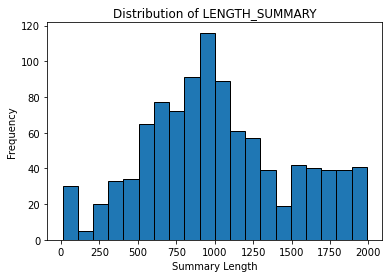

In [9]:
# 요약본 길이 변수 추가 
tmp['LENGTH_SUMMARY'] = tmp['SUMMARY'].str.len() +tmp['TITLE'].str.len()

# 요약본+제목 길이 히스토그램 그리기
plt.hist(tmp['LENGTH_SUMMARY'], bins=20, edgecolor='k')
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.title('Distribution of LENGTH_SUMMARY')
plt.show()

## 생성된 요약문의 길이가 0인 기사 확인 후 저장
- 최대 글자수를 지정하여 요약문을 생성할 경우, 글자수가 0인(결측인) 요약문이 소량 발생함
- 이러한 요약문의 경우 삭제해도 무방하지만, 본 조는 데이터의 손실을 최소화하기 위하여 수작업으로 요약문을 만들었음
    - 1) summa 로 생성한 요약문 데이터를 아래와 같이 엑셀 파일로 저장
        - 엑셀 파일명 : news_summary_over_with0.xlsx
    - 2) 엑셀 파일에서 요약문의 길이가 0인 기사는 파싱+전처리한 기사 원문 데이터를 이용하여 직접 요약문을 만들고 저장함
        - 엑셀 파일명 : news_summary_over.xlsx

In [10]:
print('생성된 요약문의 길이가 0(결측치)인 기사의 수: ', tmp[tmp['SUMMARY'].str.len() == 0]['LENGTH_SUMMARY'].count())

생성된 요약문의 길이가 0(결측치)인 기사의 수:  28


### 엑셀파일로 데이터 저장 

In [11]:
# 데이터 저장
file_path = '../../../data/News/news_summary_over_with0.xlsx'  
tmp.to_excel(file_path, index=False)